# Chicago Transit Authority Ridership and Funding EDA


## Summary

Over the last few years, Chicago public transportation has lost ridership and funding in favor of private car ownership. Ever since the pandemic of 2020, ridership was massively cut and reliability of the service became questioned by the public. In 2024, Chicago sees ridership increasing, however, locals are finding the environment dramatically changed. The largest complaints of the CTA are:
1. Increase in violant crime on the train
2. Reliability and on-time delivery
3. Health or hygiene concerns of the trains due to homelessness or drug addiction

### Objective

(Review with Marcello)

1. With the limited funding provided, can we use public data to understand where financial support should be focused?
    * Criminality trend in Chicago since 1990s
        * Sorting and trimming dataframe by cutoff date of Jan 1 1990
    * Criminality by area/neighborhood snapshot now 
    * Last 10 years, which neighborhoods improved/decreased in crime.
        * Trend of crime by level of severity (violant,petty crimes, etc)
            * Labeling by type of crime
        * Neighborhood evaluation by COL?
    * If Crime is a primary factor for loss of ridership, can we determine which locations should be prioritized with CTA police force?
        * Find data on when the CTA police size decreased - do we see a correlation with uptick in crime on the CTA or ridership?
    * Is there a correlation between police stations and crime?
    


Can we determine if safety or reliability is the biggest impact to ridership recovery? (Crime vs. late busses/trains)


What "lines" have the biggest unrecovered population and what are the commonalities that can be remedied? 


## Data Sources

Data for ridership is publically available through the CTA developer site [here](https://data.cityofchicago.org/browse?q=ridership&sortBy=relevance)

Data for L stop names and line accessibility is publically available through the CTA developer site [here](https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops-Map/zbnc-zirh)

Data for crime is posted by the city of Chicago [here](https://data.cityofchicago.org/Public-Safety/City-of-Chicago-Crime-Data/v9q9-3dm2)

Data for community names is posted by the City of Chicago [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)



## Data Dictionary and Glossary

### Crime

**Summary**
Reported crimes committed within the Chicago area and published by the Chicago Police Department. Data last refreshed as of 4th of April, 2024 00:00 (Central Standard Time / Chicago).

### Data Dictionary

**Case Number** - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.

**Date** - Date when the incident occurred. this is sometimes a best estimate.

**Block** - The partially redacted address where the incident occurred, placing it on the same block as the actual address.

**IUCR** - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.

**Primary Type** - The primary description of the IUCR code.

**Description** - The secondary description of the IUCR code, a subcategory of the primary description.

**Location Description** - Description of the location where the incident occurred.

**Arrest** - Indicates whether an arrest was made.

**Domestic** - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.

**Beat** - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.

**District** - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.

**Ward** - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.

**Community Area** - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.

**FBI Code** - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS).See the Chicago Police Department listing of these classifications at https://gis.chicagopolice.org/pages/crime_details.

**X Coordinate** - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

**Y Coordinate** - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

**Year** - Year the incident occurred.

**Updated On** - Date and time the record was last updated. 

**Latitude** - The latitude of the location where incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

**Longitude** - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

**Location** - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.

### L Stop Daily Rides

**Summary**
This list shows daily totals of ridership, by station entry, for each 'L' station dating back to 2001. Dataset shows entries at all turnstiles, combined, for each station. Daytypes are as follows: W=Weekday, A=Saturday, U=Sunday/Holiday

**station_id** - City ID for station

**stationname** - Street Intersection/Name of the station

**date** - Day of Year

**daytype** - W=Weekdays, A=Saturday, U=Sunday/Holiday

**rides** - Total rides by day for each station


### L Stop Names and Locations

**Summary**
This list of 'L' stops provides location and basic service availability information for each place on the CTA system where a train stops, along with formal station names and stop descriptions.

**STOP_D** - ID assigned by the CTA for reference in their system. 

**STOP_NAME** - Name displayed on tickers. Stop name is similar to station with the direction of the train.

**STATION_NAME** - Official name for the stop. The name is assigned based on the intersection or largest roadway.

**MAP_ID** - This appears to match the station id for the daily stop ride counts.

**ADA** - American Disability Act compliant. Refers to requirements such as a lift system as an alternative to stairs. 

**RED** - If the Red line has a stop at this station.

**BLUE** - If the Blue line has a stop at this station.

**G** - If the Green line has a stop at this station.

**BRN** - If the Brown line has a stop at this station.

**P** - If the Purple line has a stop at this station.

**Pexp** - If the Purple line express functions for this station.

**Y** - If the Yellow line has a stop at this location.

**O** - If the Orange line has a stop at this location.

**Location** - The Longitude and Latitude coordinates for this station.



### Community Area 

**Summary**
This shows the data related to the city of Chicago and how each neighborhood is organized. Data includes the geometric shape of the neighborhood and the related ID's for governance or reporting. 

**Community** - The standard name of the area or neighborhood. This is what the area is officially called and can be found on maps.

**Area Number** - The ID associated with the community. This is a reference for other records such as crime. 

**Area** - This is unknown. This is not reflected in the official site and does not correlate to the area number.

**Area Num 1** - This is the same value as the Area Number.

**Shape Area** - Appears to be the square feet of the neighboorhood.

**Geometry** - The official exact coordinates for the neighborhood.

**Shape Len** - Appears to be the *length* of the neighboor given the official shape in feet.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars
import json
import numpy as np


pd.options.display.max_columns = None

In [2]:
crimes = pd.read_csv("crimes.csv")
l_stop_daily_rides = pd.read_csv("l_stop_daily_rides.csv")
l_stop_locations = pd.read_csv("CTA_-_System_Information_-_List_of__L__Stops_-_Map.csv")


## Community Data

The community data provided by Chicago is available in a csv, however, at the time of this EDA the file was written in a way that wasn't easily digestable. We have opted to use the geojson file of the same data. To make a dataframe for this file, we have to reformat and finally load. 

Below shows the required steps to extract the information we want and load into a dataframe. 

In [3]:
with open('bounds.geojson', 'r') as file:
    comm_area_json = json.load(file)


In [4]:

community_dict = {}

for i in range(len(comm_area_json['features'])):
    community_dict_name = comm_area_json['features'][i]['properties']['community']
    community_dict_code = int(comm_area_json['features'][i]['properties']['area_num_1'])
    community_dict[community_dict_code] = community_dict_name


community_dict[0] = 'UNKNOWN'

# Understanding the Data

A review of the data is necessary to understand where unnecessary features are listed or data that needs to be sanitized before it becomes useable. Below we see each dataset reviewed for feature data types, and null/NaN values. Any features where nulls are highly present will require adjustments or dropping entirely. 

In [5]:
l_stop_daily_rides.dtypes

station_id      int64
stationname    object
date           object
daytype        object
rides           int64
dtype: object

In [6]:
crimes.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [7]:
l_stop_locations.dtypes

STOP_ID          int64
STOP_NAME       object
STATION_NAME    object
MAP_ID           int64
ADA               bool
RED               bool
BLUE              bool
G                 bool
BRN               bool
P                 bool
Pexp              bool
Y                 bool
Pnk               bool
O                 bool
Location        object
dtype: object

## Updating the Column Names

Below we condition the columns so that we follow best practices. All spaces are removed and words are lowercase for easy reference. 

In [8]:
c_cols = crimes.columns
l_cols = l_stop_daily_rides.columns
l_name_cols = l_stop_locations.columns


def minimize_cols(cols: list[str]) -> list:
    new_cols = []
    for i in range(len(cols)):
        updated_col = cols[i].lower()
        updated_col = updated_col.replace(" ","_")
        new_cols.append(updated_col)
    return new_cols



crimes.rename(columns=dict(zip(c_cols,minimize_cols(c_cols))), inplace=True)
l_stop_daily_rides.rename(columns=dict(zip(l_cols,minimize_cols(l_cols))),inplace=True)
l_stop_locations.rename(columns=dict(zip(l_name_cols,minimize_cols(l_name_cols))),inplace=True)




## Cleaning Up the Data

During the upload process most of the data was converted to the object type. Here we need to update the value types and remove any data that is invalid. Missing values or nulls can be updated depending on the characteristic and relevance to the goal. 



We can see that no values are lost for the CTA ridership data, however, our crime data is missing data in the coordinate feature. After counting the NA/Null values we can see that the missing data accounts for approximately 1.1% of the total values. With so many values completed, we will keep these values and clean up the data with best practices.



In [9]:
crime_nulls = {}
for col in crimes.columns:
    crime_nulls[col] = len(crimes[crimes[col].isna()])
crime_nulls


{'id': 0,
 'case_number': 0,
 'date': 0,
 'block': 0,
 'iucr': 0,
 'primary_type': 0,
 'description': 0,
 'location_description': 12851,
 'arrest': 0,
 'domestic': 0,
 'beat': 0,
 'district': 47,
 'ward': 614851,
 'community_area': 613475,
 'fbi_code': 0,
 'x_coordinate': 88559,
 'y_coordinate': 88559,
 'year': 0,
 'updated_on': 0,
 'latitude': 88559,
 'longitude': 88559,
 'location': 88559}

In [12]:
percent_missing = round(crime_nulls['location']/len(crimes.index),3)*100
print(f"Percent of locations missing in data set: {percent_missing}%")

Percent of locations missing in data set: 1.0999999999999999%


In [13]:
l_stop_nulls = {}
for col in l_stop_daily_rides.columns:
    l_stop_nulls[col] = len(l_stop_daily_rides[l_stop_daily_rides[col].isna()])
l_stop_nulls

{'station_id': 0, 'stationname': 0, 'date': 0, 'daytype': 0, 'rides': 0}

The date values must be converted to the appropriate datetime data type for both the L stop and crime data sets. 

In [14]:
temp_date_series = pd.to_datetime(crimes['date'])
crimes['date'] = temp_date_series
l_stop_daily_rides['date'] = pd.to_datetime(l_stop_daily_rides['date'])



### Crime Data

It would be helpful to also include the community name within the data. We will use the community dataframe to create new features based on the existing data community code / number. The missing values for crime reflects over 600,000 missing records for community. We can safely convert this feature to an integer and fill in unknowns with 0. No community uses 0 so we can safely group this data into an unknown community while it may be of use for other statistics for chicago as a whole. We use the community dictionary to create a new column matching the community id already found in the crime data. 

We can clean up a few features that don't have relation to anything with public transportation and are used more for details about the unique recorded crime. 

In [15]:
crimes['community_area'] = crimes['community_area'].fillna(0).copy()

crimes['community_area'] = crimes['community_area'].astype('Int64')

crimes['community_name'] = crimes['community_area'].apply(lambda x: community_dict[x])

In [16]:
crimes.drop(['case_number','x_coordinate','y_coordinate','updated_on','fbi_code'], axis=1, inplace=True)
crimes.set_index('id', inplace=True)

In [17]:
crimes['location'] = crimes['location'].fillna('Not Available').copy()

In [18]:
# Pandas at the time of this EDA has a bug that does not allow direct dt conversion and reassignment
temp_date_series = pd.to_datetime(crimes['date'])
crimes['date'] = temp_date_series 

In [19]:
crimes.head()

,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,year,latitude,longitude,location,community_name
id,,,,,,,,,,,,,,,,,
5741943,2007-08-25 09:22:18,074XX N ROGERS AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,2422,24.0,49.0,1,2007,NaN,NaN,Not Available,ROGERS PARK
25953,2021-05-24 15:06:00,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,2515,25.0,36.0,19,2021,41.917838,-87.755969,"(41.917838056, -87.755968972)",BELMONT CRAGIN
26038,2021-06-26 09:24:00,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,1711,17.0,50.0,13,2021,41.995219,-87.713355,"(41.995219444, -87.713354912)",NORTH PARK
13279676,2023-11-09 07:30:00,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,1922,19.0,47.0,5,2023,41.952345,-87.677975,"(41.952345086, -87.677975059)",NORTH CENTER
13274752,2023-11-12 07:59:00,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",SMALL RETAIL STORE,True,False,632,6.0,6.0,44,2023,41.737751,-87.604856,"(41.737750767, -87.604855911)",CHATHAM


### L Stops

The daily ride data is very clean so we don't need to change much. For future review, we are going to merge the daily ride count and the relevant data from the location. We drop the duplicate values ```map_id``` and ```station_name``` for readability. 

In [20]:
l_stop_daily_rides = l_stop_daily_rides.merge(l_stop_locations,left_on='station_id', right_on='map_id', how='outer').drop([
    'map_id',
    'station_name',
],axis=1).copy()

In [21]:
l_stop_daily_rides.head()

,station_id,stationname,date,daytype,rides,stop_id,stop_name,ada,red,blue,g,brn,p,pexp,y,pnk,o,location
0,40010,Austin-Forest Park,2017-12-03,U,641,30001.0,Austin (O'Hare-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
1,40010,Austin-Forest Park,2017-12-03,U,641,30002.0,Austin (Forest Pk-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
2,40010,Austin-Forest Park,2017-12-28,W,1155,30001.0,Austin (O'Hare-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
3,40010,Austin-Forest Park,2017-12-28,W,1155,30002.0,Austin (Forest Pk-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
4,40010,Austin-Forest Park,2017-12-13,W,1916,30001.0,Austin (O'Hare-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"


Any missing L stops need to be updated so that crimes can be properly assigned. Due to the limited amount stations we can validate if a record is simply missing data due to poor entry or if all entries of the same stop are missing data. 

We capture the stops that are missing data below by creating a null mask and compare each stop to stops that contain location. The final dictionary shows stops that have zero records with location as False and records with some location as True. 

Because there are only a handful of stops missing location, We search the address and use one of many geolocation finder sites to fill in the coordinates. 

For addresses, I used a chicago l [history site](https://www.chicago-l.org/stations/randolph-wabash.html) and coordinates from [latlong](https://www.latlong.net)

For stations that have multiple addresses, I used the first listed on the site to avoid issues with future longitude/latitude uses.


In [22]:
# Find L stops with missing location 
l_no_location = l_stop_daily_rides[l_stop_daily_rides['location'].isna()]

no_loc = l_no_location['stationname'].unique()

l_yes_location = l_stop_daily_rides[~l_stop_daily_rides['location'].isna()]

yes_loc = l_yes_location['stationname'].unique()

is_in = {i: i in yes_loc for i in no_loc}

print(is_in)




{'Randolph/Wabash': False, 'Washington/State': False, 'Madison/Wabash': False, 'Homan': False}


In [23]:

l_stop_daily_rides.loc[l_stop_daily_rides["stationname"] == "Randolph/Wabash", "location"] = "(41.884260,-87.626130)"
l_stop_daily_rides.loc[l_stop_daily_rides["stationname"] == "Washington/State", "location"] = "(41.883900, -87.628070)"
l_stop_daily_rides.loc[l_stop_daily_rides["stationname"] == "Madison/Wabash", "location"] = "(41.882280, -87.626370)"
l_stop_daily_rides.loc[l_stop_daily_rides["stationname"] == "Homan", "location"] = "(41.884850, -87.711300)"


In [24]:

l_stop_daily_rides['latitude'] = l_stop_daily_rides['location'].apply(lambda x: eval(x)[0])
l_stop_daily_rides['longitude'] = l_stop_daily_rides['location'].apply(lambda x: eval(x)[1])



### Filtering Crime Data

This EDA is focusing on the impact of crime *on the CTA* thus we can safely remove crime that is outside an accepted distance from CTA stations. A study on impact of crime on real estate was published on Taylor and Francis online named *Nordic Journal of Criminology - Do crime hotspots impact housing prices* linked [here](https://www.tandfonline.com/doi/full/10.1080/2578983X.2019.1662595). 

The observable impact to real estate prices were shown as extremely close (under 500 meters) and no significant impact over 1 kilometer. We can use this distance to filter out crimes that occur outside of the ranges outside of 1 kilometer from a station.  

In [25]:
from geopy import distance
from joblib import Parallel, delayed


l_stop_coords = {}

stops = ['Austin-Forest Park', 'Harlem-Lake', 'Pulaski-Lake',
       'Quincy/Wells', 'Davis', "Belmont-O'Hare", 'Jackson/Dearborn',
       'Sheridan', 'Damen-Brown', 'Morse', '35th/Archer', '51st',
       'Dempster-Skokie', 'Skokie', 'Pulaski-Cermak', 'LaSalle/Van Buren',
       'Ashland-Lake', 'Oak Park-Forest Park', 'Sox-35th-Dan Ryan',
       'Randolph/Wabash', 'Damen-Cermak', 'Western-Forest Park',
       'Cumberland', '79th', 'Kedzie-Homan-Forest Park', 'State/Lake',
       'Main', 'Central-Lake', 'Ashland/63rd', 'Indiana',
       'Western-Orange', 'Division/Milwaukee', 'Grand/State', 'Berwyn',
       'UIC-Halsted', 'Southport', 'Washington/Dearborn', 'Clark/Lake',
       'Forest Park', 'Noyes', 'Cicero-Cermak', 'Clinton-Forest Park',
       'California-Cermak', '95th/Dan Ryan', 'Merchandise Mart', 'Racine',
       'Cicero-Lake', 'Grand/Milwaukee', 'Washington/State',
       'Garfield-South Elevated', 'Foster', 'Diversey', 'Wilson',
       "Irving Park-O'Hare", 'Jackson/State', 'California/Milwaukee',
       '54th/Cermak', 'Damen/Milwaukee', 'Kostner', 'Ridgeland',
       'Clark/Division', 'Madison/Wabash', 'North/Clybourn', 'Armitage',
       'Western/Milwaukee', 'Adams/Wabash', 'Dempster', 'Laramie',
       'Chicago/Franklin', 'East 63rd-Cottage Grove', 'Washington/Wells',
       'Western-Cermak', "Harlem-O'Hare", 'Granville', 'Lawrence',
       'Central Park', 'Monroe/Dearborn', 'Sedgwick', 'Medical Center',
       'Rosemont', '18th', 'South Boulevard', 'Library', 'Francisco',
       'Thorndale', "O'Hare Airport", 'Howard', '63rd-Dan Ryan',
       'Pulaski-Forest Park', 'Midway Airport', 'Halsted/63rd',
       'Pulaski-Orange', 'Cicero-Forest Park', 'Harlem-Forest Park',
       '69th', 'Cermak-Chinatown', 'Rockwell', 'Logan Square', 'Polk',
       'Kedzie-Cermak', 'Linden', 'Ashland-Orange', 'Kedzie-Lake',
       '47th-South Elevated', 'Monroe/State', '35-Bronzeville-IIT',
       'Halsted-Orange', 'King Drive', 'Kedzie-Midway', 'Clinton-Lake',
       'Garfield-Dan Ryan', 'Kedzie-Brown', 'Jarvis', 'Argyle',
       'Wellington', 'Fullerton', '47th-Dan Ryan', "Addison-O'Hare",
       'Central-Evanston', 'Austin-Lake', '43rd', 'Jefferson Park',
       'Kimball', 'Loyola', 'Paulina', 'Belmont-North Main',
       "Montrose-O'Hare", 'LaSalle', 'Oak Park-Lake', 'California-Lake',
       'Bryn Mawr', 'Roosevelt', 'Chicago/Milwaukee',
       'Addison-North Main', '87th', 'Addison-Brown', 'Chicago/State',
       'Irving Park-Brown', 'Western-Brown', 'Harrison', 'Montrose-Brown',
       'Morgan-Lake', 'Homan', 'Lake/State', 'Conservatory',
       'Oakton-Skokie', 'Cermak-McCormick Place', 'Washington/Wabash']


for val in stops:
    item = l_stop_daily_rides[l_stop_daily_rides['stationname'] == val].iloc[0]
    item_name = item['stationname']
    item_name = item_name.replace("/","_")
    item_name = item_name.replace("'","")
    item_name = item_name.replace(" ","_")
    item_name = item_name.replace("-","_")
    item_name = item_name.lower()
    l_stop_coords[item_name] = (item['latitude'],item['longitude'])

print(l_stop_coords)


{'austin_forest_park': (41.870851, -87.776812), 'harlem_lake': (41.886848, -87.803176), 'pulaski_lake': (41.885412, -87.725404), 'quincy_wells': (41.878723, -87.63374), 'davis': (42.04771, -87.683543), 'belmont_ohare': (41.938132, -87.712359), 'jackson_dearborn': (41.878183, -87.629296), 'sheridan': (41.953775, -87.654929), 'damen_brown': (41.966286, -87.678639), 'morse': (42.008362, -87.665909), '35th_archer': (41.829353, -87.680622), '51st': (41.80209, -87.618487), 'dempster_skokie': (42.038951, -87.751919), 'skokie': (42.038951, -87.751919), 'pulaski_cermak': (41.853732, -87.724311), 'lasalle_van_buren': (41.8768, -87.631739), 'ashland_lake': (41.885269, -87.666969), 'oak_park_forest_park': (41.872108, -87.791602), 'sox_35th_dan_ryan': (41.831191, -87.630636), 'randolph_wabash': (41.88426, -87.62613), 'damen_cermak': (41.854517, -87.675975), 'western_forest_park': (41.875478, -87.688436), 'cumberland': (41.984246, -87.838028), '79th': (41.750419, -87.625112), 'kedzie_homan_forest_pa

In [26]:
l_stop_daily_rides[l_stop_daily_rides['latitude'] == 0.0]['stationname'].unique()

array([], dtype=object)

Due to the size of the data, the code below was ran previously and saved to a csv for future use. Using multithreading, this can still take about 2-3 hours to complete the transformation. We will keep this as a record of what must be completed to move forward.

```

crimes['latitude'] = crimes['latitude'].fillna(0.0)
crimes['longitude'] = crimes['longitude'].fillna(0.0)

# Function to calculate distance
def calculate_distance_for_stop(crime_coords, stop_coords):
    stop_coords_array = np.array(stop_coords)
    return np.apply_along_axis(
        lambda crime_coord: distance.distance(crime_coord, stop_coords_array).kilometers,
        1,
        crime_coords
    )

# Main function to calculate distances in parallel
def calculate_distances(crime_df, coords):
    crime_coords = crime_df[['latitude', 'longitude']].to_numpy()
    
    # Parallel processing
    results = Parallel(n_jobs=-1)(
        delayed(calculate_distance_for_stop)(crime_coords, stop_coords)
        for stop_name, stop_coords in coords.items()
    )
    
    # Combine results into a DataFrame
    distances = {stop_name: result for stop_name, result in zip(coords.keys(), results)}
    dist_df = pd.DataFrame(distances, index=crime_df.index)
    
    return dist_df

# Calculate distances
new_crime_cols = calculate_distances(crimes, l_stop_coords)

# Add the new columns to the original DataFrame
crimes = pd.concat([crimes, new_crime_cols], axis=1)

```

Saving the calculated dataframe to a csv

```
crimes.to_csv("distance_calc_crimes.csv")
````

In [27]:
crimes = pd.read_csv("distance_calc_crimes.csv")

In [31]:
# Function that creates a mask for distance of crime from the coordinates of the L stops

def dist_compare(row, dist):
    return any([x < dist for x in row])

crime_mask = crimes.iloc[:,18::].apply(dist_compare,axis=1,args=[0.4])

crimes_500 = crimes[crime_mask].copy()



In [32]:
crimes_500.head()

,id,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,year,latitude,longitude,location,community_name,austin_forest_park,harlem_lake,pulaski_lake,quincy_wells,davis,belmont_ohare,jackson_dearborn,sheridan,damen_brown,morse,35th_archer,51st,dempster_skokie,skokie,pulaski_cermak,lasalle_van_buren,ashland_lake,oak_park_forest_park,sox_35th_dan_ryan,randolph_wabash,damen_cermak,western_forest_park,cumberland,79th,kedzie_homan_forest_park,state_lake,main,central_lake,ashland_63rd,indiana,western_orange,division_milwaukee,grand_state,berwyn,uic_halsted,southport,washington_dearborn,clark_lake,forest_park,noyes,cicero_cermak,clinton_forest_park,california_cermak,95th_dan_ryan,merchandise_mart,racine,cicero_lake,grand_milwaukee,washington_state,garfield_south_elevated,foster,diversey,wilson,irving_park_ohare,jackson_state,california_milwaukee,54th_cermak,damen_milwaukee,kostner,ridgeland,clark_division,madison_wabash,north_clybourn,armitage,western_milwaukee,adams_wabash,dempster,laramie,chicago_franklin,east_63rd_cottage_grove,washington_wells,western_cermak,harlem_ohare,granville,lawrence,central_park,monroe_dearborn,sedgwick,medical_center,rosemont,18th,south_boulevard,library,francisco,thorndale,ohare_airport,howard,63rd_dan_ryan,pulaski_forest_park,midway_airport,halsted_63rd,pulaski_orange,cicero_forest_park,harlem_forest_park,69th,cermak_chinatown,rockwell,logan_square,polk,kedzie_cermak,linden,ashland_orange,kedzie_lake,47th_south_elevated,monroe_state,35_bronzeville_iit,halsted_orange,king_drive,kedzie_midway,clinton_lake,garfield_dan_ryan,kedzie_brown,jarvis,argyle,wellington,fullerton,47th_dan_ryan,addison_ohare,central_evanston,austin_lake,43rd,jefferson_park,kimball,loyola,paulina,belmont_north_main,montrose_ohare,lasalle,oak_park_lake,california_lake,bryn_mawr,roosevelt,chicago_milwaukee,addison_north_main,87th,addison_brown,chicago_state,irving_park_brown,western_brown,harrison,montrose_brown,morgan_lake,homan,lake_state,conservatory,oakton_skokie,cermak_mccormick_place,washington_wabash
3,13279676,2023-11-09 07:30:00,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,1922,19.0,47.0,5,2023,41.952345,-87.677975,"(41.952345086, -87.677975059)",NORTH CENTER,12.213658,12.680441,8.411317,8.963020,10.602535,3.259055,9.173996,1.917375,1.549430,6.301808,13.662640,17.404205,11.404973,11.404973,11.608301,9.226099,7.505991,12.972786,14.018499,8.699796,10.867171,8.581747,13.732104,22.853599,8.971443,8.487058,9.010175,10.244522,19.305184,15.249058,16.423845,5.524093,7.911790,3.266708,8.854415,1.526328,8.675032,8.366222,14.452279,11.775153,12.486371,9.066172,10.999896,25.928153,7.931252,8.626544,9.170233,7.245615,8.656470,18.146009,11.318385,2.998357,2.147554,4.250064,9.239919,3.723791,12.940134,4.731996,11.872920,11.370371,6.621634,8.882046,5.210314,4.333899,4.094214,9.166109,9.924491,9.655461,7.086297,20.024295,8.560954,10.914490,11.350363,4.846013,2.467394,11.360812,8.920414,5.655485,8.519033,15.430938,10.514808,8.360180,9.345946,2.483194,4.493123,18.964771,7.422521,19.478207,9.579612,19.068188,19.462428,17.382546,10.561690,13.828475,20.890030,11.681923,2.031335,3.568716,9.001236,11.161895,13.460092,12.607229,7.908934,16.639102,8.980207,14.084183,11.984668,19.817841,16.596272,7.990369,17.857863,2.972958,7.094862,2.845204,2.735122,3.677858,16.251016,3.450940,12.416600,10.762819,15.866077,7.167753,3.383481,5.590948,1.132262,2.473076,5.533627,9.351318,12.041138,7.716885,3.807063,10.329168,6.528960,2.091488,24.501818,0.652045,7.436589,0.353234,1.765566,9.653927,1.073111,7.717334,7.990272,8.578245,8.144808,10.014899,11.823247,8.798018
6,13203321,2023-09-06 17:00:00,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,122,1.0,42.0,32,2023,41.886018,-87.633938,"(41.886018055, -87.633937881)",LOOP,11.978780,14.046711,7.591880,0.810436,18.424267,8.708373,0.951725,7.724703,9.655780,13.845191,7.391804,9.409820,19.6011

In [33]:
l_stop_daily_rides.head()

,station_id,stationname,date,daytype,rides,stop_id,stop_name,ada,red,blue,g,brn,p,pexp,y,pnk,o,location,latitude,longitude
0,40010,Austin-Forest Park,2017-12-03,U,641,30001.0,Austin (O'Hare-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)",41.870851,-87.776812
1,40010,Austin-Forest Park,2017-12-03,U,641,30002.0,Austin (Forest Pk-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)",41.870851,-87.776812
2,40010,Austin-Forest Park,2017-12-28,W,1155,30001.0,Austin (O'Hare-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)",41.870851,-87.776812
3,40010,Austin-Forest Park,2017-12-28,W,1155,30002.0,Austin (Forest Pk-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)",41.870851,-87.776812
4,40010,Austin-Forest Park,2017-12-13,W,1916,30001.0,Austin (O'Hare-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)",41.870851,-87.776812


In [48]:
grouped_crimes_count = crimes.groupby(crimes['date'].dt.year)['arrest'].count()
crime_years = (crimes['date'].dt.year).unique()

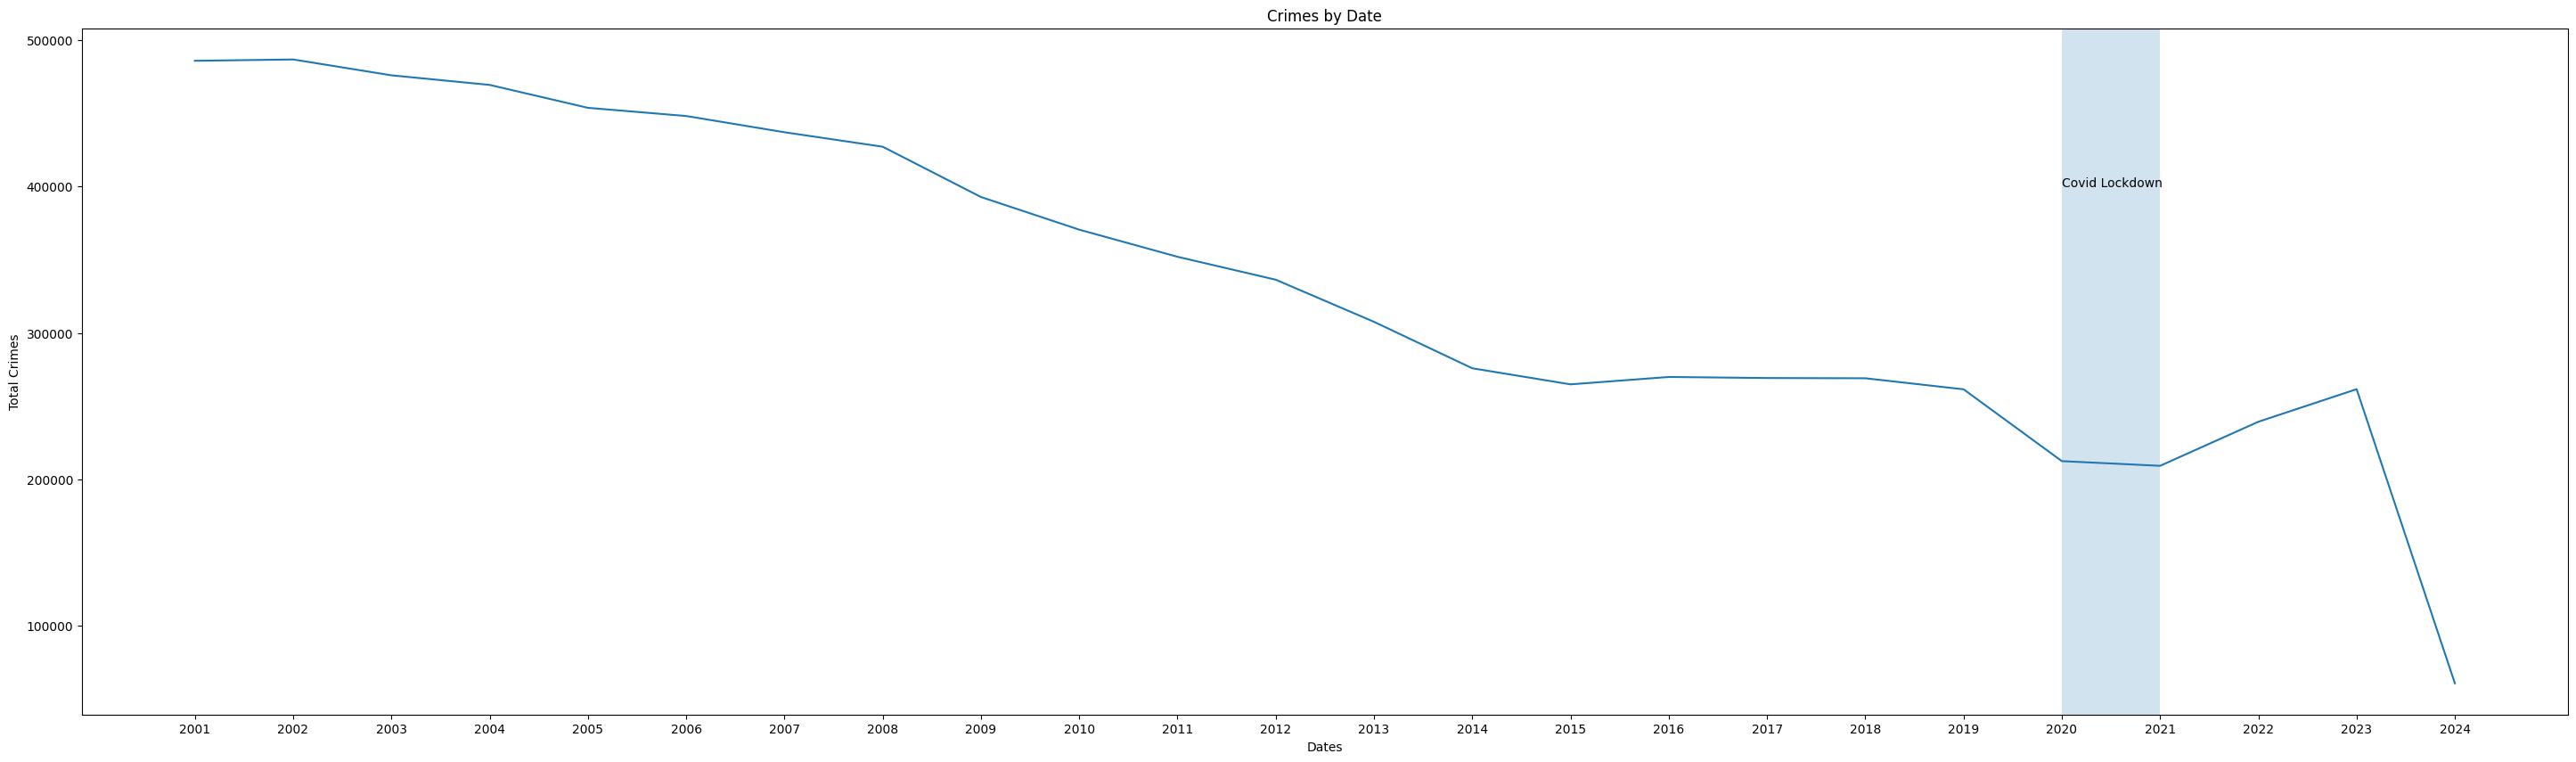

In [71]:
plt.figure(figsize=(36,10))
sns.lineplot(grouped_crimes_count)
plt.title('Crimes by Date')
plt.xlabel('Dates')
plt.xticks(np.arange(crime_years.min(),(crime_years.max())+1, 1))
plt.ylabel('Total Crimes')
# plt.vlines(x=2021,ymin=0,ymax=500000)
area_transparency = 0.2
plt.text(x=2020,y=400000,s='Covid Lockdown')
plt.axvspan(xmin=2020,xmax=2021,ymin=0,ymax=grouped_crimes_count.max(),alpha=area_transparency)
plt.show()

In [72]:
l_stop_rides_by_year = l_stop_daily_rides.copy()
l_stop_rides_by_year['date'] = l_stop_rides_by_year['date'].dt.year
# daily_ride_avg = l_stop_rides_by_year.groupby(['date','stationname'])['rides'].mean()
daily_ride_avg = l_stop_rides_by_year.groupby(['date','stationname'])
# plt.figure(figsize=(36,10))
# sns.lineplot(daily_ride_avg)
# plt.plot()
daily_ride_avg.head(1)

,station_id,stationname,date,daytype,rides,stop_id,stop_name,ada,red,blue,g,brn,p,pexp,y,pnk,o,location,latitude,longitude
0,40010,Austin-Forest Park,2017,U,641,30001.0,Austin (O'Hare-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)",41.870851,-87.776812
62,40010,Austin-Forest Park,2018,W,2248,30001.0,Austin (O'Hare-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)",41.870851,-87.776812
730,40010,Austin-Forest Park,2019,W,1870,30001.0,Austin (O'Hare-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)",41.870851,-87.776812
1216,40010,Austin-Forest Park,2020,U,511,30001.0,Austin (O'Hare-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)",41.870851,-87.776812
2254,40010,Austin-Forest Park,2021,W,495,30001.0,Austin (O'Hare-bound),False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)",41.870851,-87.776812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475347,41700,Washington/Wabash,2019,U,2690,30384.0,Washington/Wabash (Inner Loop),True,False,False,True,False,False,True,False,True,True,"(41.88322, -87.626189)",41.883220,-87.626189
2476077,41700,Washington/Wabash,2020,U,2972,30384.0,Washington/Wabash (Inner Loop),True,False,False,True,False,False,True,False,True,True,"(41.88322, -87.626189)",41.883220,-87.626189
2476809,41700,Washington/Wabash,2021,U,887,30384.0,Washington/Wabash (Inner Loop),True,False,False,True,False,False,True,False,True,True,"(41.88322, -87.626189)",41.883220,-87.626189
2477539,41700,Washington/Wabash,2022,A,1542,30384.0,Washington/Wabash (Inner Loop),True,False,False,True,False,False,True,False,True,True,"(41.88322, -87.626189)",41.883220,-87.626189


In [ ]:
l_stop_daily_rides['date'].dt.year

0          2017
1          2017
2          2017
3          2017
4          2017
           ... 
2479116    2023
2479117    2023
2479118    2023
2479119    2023
2479120    2023
Name: date, Length: 2479121, dtype: int32